# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [9]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1
HopsworksSettings initialized!


In [10]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [11]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 10, 0, 10, 634742)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [12]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-18 10:00:12,380 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 10:00:12,384 INFO: Initializing external client
2025-11-18 10:00:12,384 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 10:00:13,678 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286353


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [16]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=3,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 10:04:10,579 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/517199 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111837 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/16901 elapsed<00:00 remaining<?

In [17]:
import os

print("Model path:", saved_model_dir + "/model.json")
print("Exists:", os.path.exists(saved_model_dir + "/model.json"))


Model path: /var/folders/8l/fwlkdsgn45jcvzw1npj16x3w0000gn/T/3c50365c-7398-4b5b-a04d-73a5f170f618/air_quality_xgboost_model/3/model.json
Exists: True


In [18]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.4138298E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [19]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-24 00:00:00+00:00,2.70,0.0,11.269782,63.435013,Stockholm
1,2025-11-20 00:00:00+00:00,1.05,0.1,16.394829,8.841739,Stockholm
2,2025-11-19 00:00:00+00:00,-1.40,0.0,4.735060,351.253906,Stockholm
3,2025-11-21 00:00:00+00:00,-3.45,0.1,15.575981,303.690094,Stockholm
4,2025-11-23 00:00:00+00:00,3.35,0.1,10.144082,117.474350,Stockholm
5,2025-11-22 00:00:00+00:00,1.50,0.0,15.463246,245.224884,Stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [20]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-24 00:00:00+00:00,2.70,0.0,11.269782,63.435013,Stockholm,27.874228
1,2025-11-20 00:00:00+00:00,1.05,0.1,16.394829,8.841739,Stockholm,18.816196
2,2025-11-19 00:00:00+00:00,-1.40,0.0,4.735060,351.253906,Stockholm,41.791885
3,2025-11-21 00:00:00+00:00,-3.45,0.1,15.575981,303.690094,Stockholm,22.989374
4,2025-11-23 00:00:00+00:00,3.35,0.1,10.144082,117.474350,Stockholm,29.658939
5,2025-11-22 00:00:00+00:00,1.50,0.0,15.463246,245.224884,Stockholm,23.511532


In [21]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 344.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [22]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
2,2025-11-19 00:00:00+00:00,-1.40,0.0,4.735060,351.253906,Stockholm,41.791885,stockholm-st-eriksgatan-83,Sweden,3
1,2025-11-20 00:00:00+00:00,1.05,0.1,16.394829,8.841739,Stockholm,18.816196,stockholm-st-eriksgatan-83,Sweden,2
3,2025-11-21 00:00:00+00:00,-3.45,0.1,15.575981,303.690094,Stockholm,22.989374,stockholm-st-eriksgatan-83,Sweden,4
5,2025-11-22 00:00:00+00:00,1.50,0.0,15.463246,245.224884,Stockholm,23.511532,stockholm-st-eriksgatan-83,Sweden,6
4,2025-11-23 00:00:00+00:00,3.35,0.1,10.144082,117.474350,Stockholm,29.658939,stockholm-st-eriksgatan-83,Sweden,5
0,2025-11-24 00:00:00+00:00,2.70,0.0,11.269782,63.435013,Stockholm,27.874228,stockholm-st-eriksgatan-83,Sweden,1


In [23]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 2 to 0
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
 7   street                       6 non-null      object                 
 8   country                      6 non-null      object                 
 9   days_before_forecast_day     6 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

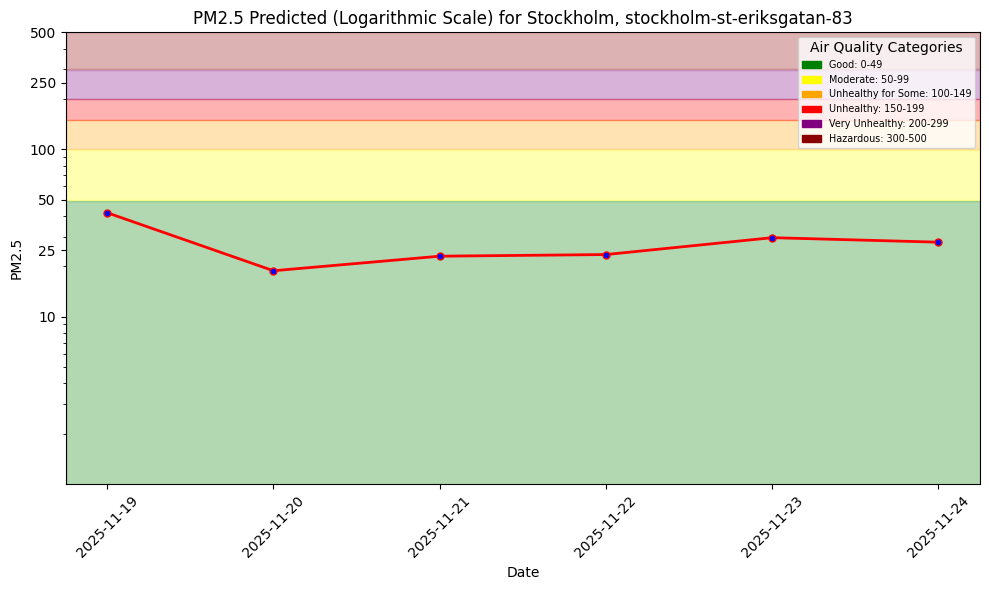

In [25]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [26]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [27]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286353/fs/1273974/fg/1718935


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286353/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 10:05:55,076 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 10:05:58,253 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 10:07:27,279 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 10:07:27,434 INFO: Waiting for log aggregation to finish.
2025-11-18 10:07:36,074 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [29]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.98s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-24 00:00:00+00:00,2.7,0.0,11.269782,63.435013,Stockholm,27.874228,stockholm-st-eriksgatan-83,Sweden,1


In [30]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 


,date,pm25,country,city,street,url
0,2024-12-03 00:00:00+00:00,10.0,Sweden,Stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523/
1,2020-04-18 00:00:00+00:00,12.0,Sweden,Stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523/
2,2025-02-12 00:00:00+00:00,22.0,Sweden,Stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523/
3,2025-02-28 00:00:00+00:00,29.0,Sweden,Stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523/
4,2025-04-09 00:00:00+00:00,25.0,Sweden,Stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523/
...,...,...,...,...,...,...
2520,2025-05-11 00:00:00+00:00,18.0,Sweden,Stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523/
2521,2025-01-17 00:00:00+00:00,27.0,Sweden,Stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523/
2522,2022-01-30 00:00:00+00:00,5.0,Sweden,Stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523/
2523,2021-01-24 00:00:00+00:00,32.0,Sweden,Stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523/


In [31]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.10s) 


Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286353/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 10:09:20,214 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 10:09:23,389 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 10:11:08,280 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 10:11:08,439 INFO: Waiting for log aggregation to finish.
2025-11-18 10:11:17,069 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-15 00:00:00+00:00,-0.055917,0.0,18.491003,264.941376,Stockholm,19.203537,12.0,stockholm-st-eriksgatan-83,Sweden,1
1,2025-11-16 00:00:00+00:00,0.804500,0.2,17.799076,249.588333,Stockholm,27.221914,15.0,stockholm-st-eriksgatan-83,Sweden,1
2,2025-11-17 00:00:00+00:00,-2.243417,0.0,12.906138,319.676941,Stockholm,26.204088,18.0,stockholm-st-eriksgatan-83,Sweden,1
3,2025-11-18 00:00:00+00:00,-1.800000,0.0,7.594208,301.429504,Stockholm,44.450752,15.0,stockholm-st-eriksgatan-83,Sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

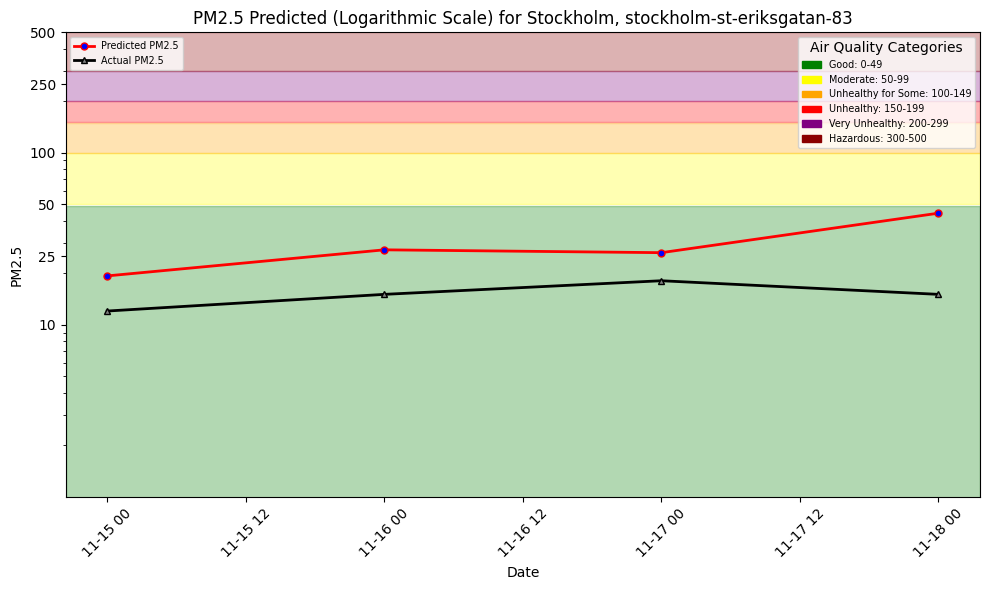

In [32]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [33]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/docs/air-quality/assets/img/pm25_forecast.png: 0.000%…

Uploading /Users/yuxinjin/Desktop/KTH/Second-P2/SML/Lab1/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286353/settings/fb/path/Resources/airquality


---